## **Brain Tumor Classification**

Transfer Learning EfficientNetB1 model

## **1. Setup**

### **1.1 Imports**

In [1]:
# Import necessary libraries
import pathlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### **1.2 Constants**

In [2]:
BATCH_SIZE = 16
IMG_SIZE = 240
CLASS_MODE_SPARSE = 'sparse'
INTERPOLATION_BILINEAR = 'bilinear'
SEED = 1234

## **2. Load dataset**

### **2.1 Clone data on Google Colab**

In [3]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [4]:
!ls /content/Brain-Tumor-Classification-DataSet/

Testing  Training


In [5]:
# Train set and test set data directory
train_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Training')
test_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Testing')

### **2.2 Load data and perform image augmentation**

#### **2.2.1. Create image data generators**

In [6]:
# Data generator without image augmentation
datagen_normal = ImageDataGenerator()

# Data generator with image augmentation
datagen_aug = ImageDataGenerator(rotation_range=10,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='constant',
                                 validation_split=0.2
)

#### **2.2.2 Load data**

In [7]:
# Training set
train_data = datagen_aug.flow_from_directory(train_data_dir, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             batch_size=BATCH_SIZE, 
                                             class_mode='sparse',
                                             subset='training')

Found 2297 images belonging to 4 classes.


In [8]:
# Validation set
val_data = datagen_aug.flow_from_directory(train_data_dir, 
                                           target_size=(IMG_SIZE, IMG_SIZE), 
                                           batch_size=BATCH_SIZE, 
                                           class_mode='sparse',
                                           subset='validation')

Found 573 images belonging to 4 classes.


In [9]:
# Testing set
test_data = datagen_normal.flow_from_directory(test_data_dir, 
                                               target_size=(IMG_SIZE, IMG_SIZE), 
                                               class_mode='sparse')

Found 394 images belonging to 4 classes.


In [10]:
num_classes = 4

In [11]:
train_data.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

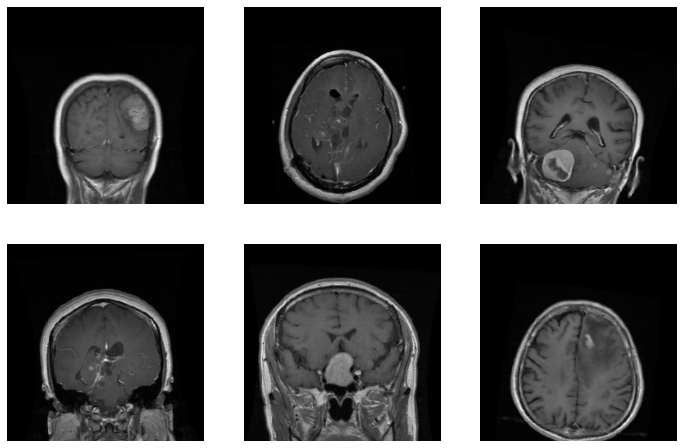

In [12]:
# View 6 samples of the augmented images
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sample = array_to_img(sample_x[i])
    plt.axis('off')
    plt.grid(False)
    plt.imshow(sample)
plt.show()

#### **2.2.3 Compute the class weight**

In [13]:
# Get the Training set labels
train_labels = np.array([])

for batch in range(len(train_data)):
    x, y = train_data[batch]
    train_labels = np.concatenate([train_labels, y])

In [14]:
# Compute class weight
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', 
                                                                      classes=np.asarray(range(4)), 
                                                                      y=train_labels)))
print(class_weights_dict)

{0: 0.8687594553706506, 1: 0.8727203647416414, 2: 1.817246835443038, 3: 0.8674471299093656}


## **3. Build our CNN model based on EfficientNetB1 model**

Use EfficientNet as a feature extractor in our transfer learning workflow.

In [15]:
base_model = EfficientNetB1(weights='imagenet',  # Use ImageNet pre-trained weights
                            include_top=False,   # Do not include classifer at the top
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the pretrained weights
base_model.trainable = False

In [16]:
# Rebuild model top
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax', name='predict')(x)
model = Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 4100  

In [19]:
num_train_epochs = 15
train_history = model.fit(train_data, 
                          epochs=num_train_epochs, 
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 1/15
144/144 [==============================] - 47s 272ms/step - loss: 0.8260 - accuracy: 0.6783 - val_loss: 0.7967 - val_accuracy: 0.6632
Epoch 2/15
144/144 [==============================] - 38s 261ms/step - loss: 0.4825 - accuracy: 0.8124 - val_loss: 0.6209 - val_accuracy: 0.7487
Epoch 3/15
144/144 [==============================] - 38s 261ms/step - loss: 0.3680 - accuracy: 0.8472 - val_loss: 0.5428 - val_accuracy: 0.7818
Epoch 4/15
144/144 [==============================] - 38s 261ms/step - loss: 0.3063 - accuracy: 0.8798 - val_loss: 0.4891 - val_accuracy: 0.8220
Epoch 5/15
144/144 [==============================] - 38s 261ms/step - loss: 0.2814 - accuracy: 0.8899 - val_loss: 0.4768 - val_accuracy: 0.8185
Epoch 6/15
144/144 [==============================] - 38s 262ms/step - loss: 0.2232 - accuracy: 0.9138 - val_loss: 0.4365 - val_accuracy: 0.8534
Epoch 7/15
144/144 [==============================] - 38s 262ms/step - loss: 0.2166 - accuracy: 0.9203 - val_loss: 0.4760 - val_ac

The train accuracy is 96.47% and the validation accuracy is 83.94%.

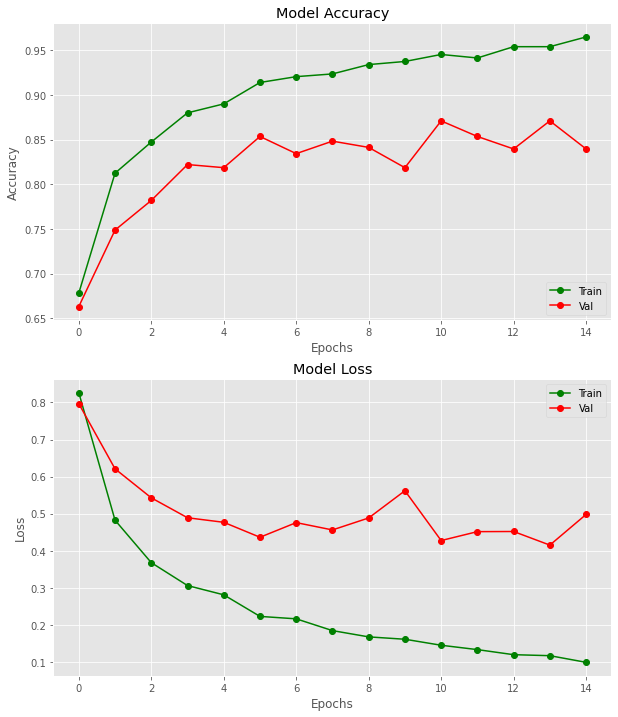

In [20]:
# Plot the training curves
train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))
#epochs = range(1,11)

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


Evaluate model performance on the test dataset:

In [21]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 1.6196 - accuracy: 0.7513
Test accuracy is 75.13%


The test accuracy is 75.13% which is slightly better than our baseline model.  We will fine-tune the model to see if the model can improve in accuracy.

## **4. Fine-tune the base EfficientNetB1 model**

In [22]:
# Structure of the EfficientNetB1 model
model.layers[1].summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 240, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 241, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

To fine-tune the model, we choose to unfreeze the layers in block 7 while leaving the BatchNormalization layers frozen.

In [23]:
print("Number of layers in EfficientNetB1 model: ", len(base_model.layers))

Number of layers in EfficientNetB1 model:  339


In [24]:
# Function to return the index of a layer with the name of the layer
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx


fine_tune_at_layer_idx = getLayerIndexByName(base_model, 'block7a_expand_conv')
print("Unfreeze the EfficientNetB1 model starting at layer", fine_tune_at_layer_idx)

Unfreeze the EfficientNetB1 model starting at layer 308


In [25]:
# Set all layers in block 7 to trainable while keeping the BatchNormalization layers frozen
base_model.trainable = True

# Keep the bottom layers frozen
for layer in base_model.layers[:fine_tune_at_layer_idx]:
    layer.trainable = False

# Keep the BatchNormalization layers at the top frozen
for layer in base_model.layers[fine_tune_at_layer_idx:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 4100  

In [27]:
model.compile(optimizer=Adam(learning_rate=base_learning_rate/10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
num_tune_epochs = 50
total_epochs = num_train_epochs + num_tune_epochs
tuned_history = model.fit(train_data, 
                          epochs=total_epochs,
                          initial_epoch=train_history.epoch[-1] ,
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 15/65
144/144 [==============================] - 46s 274ms/step - loss: 0.1000 - accuracy: 0.9656 - val_loss: 0.4638 - val_accuracy: 0.8499
Epoch 16/65
144/144 [==============================] - 38s 263ms/step - loss: 0.0856 - accuracy: 0.9669 - val_loss: 0.5057 - val_accuracy: 0.8307
Epoch 17/65
144/144 [==============================] - 38s 262ms/step - loss: 0.0899 - accuracy: 0.9673 - val_loss: 0.4477 - val_accuracy: 0.8656
Epoch 18/65
144/144 [==============================] - 41s 283ms/step - loss: 0.0852 - accuracy: 0.9687 - val_loss: 0.4352 - val_accuracy: 0.8726
Epoch 19/65
144/144 [==============================] - 38s 263ms/step - loss: 0.0833 - accuracy: 0.9704 - val_loss: 0.4472 - val_accuracy: 0.8517
Epoch 20/65
144/144 [==============================] - 38s 263ms/step - loss: 0.0727 - accuracy: 0.9713 - val_loss: 0.4847 - val_accuracy: 0.8586
Epoch 21/65
144/144 [==============================] - 38s 262ms/step - loss: 0.0739 - accuracy: 0.9734 - val_loss: 0.4684 -

In [29]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 1s - loss: 1.6568 - accuracy: 0.7614
Test accuracy is 76.14%


Unfreezing the last block helps to improve the test accuracy from 75.13% to 76.14% which is about 1%.  Comparing to our original baseline model with a 73.60% test accuracy, the model performs a little  better.

## **5. Model Evaluation**

### **5.1 Training and validation accuracy and loss**

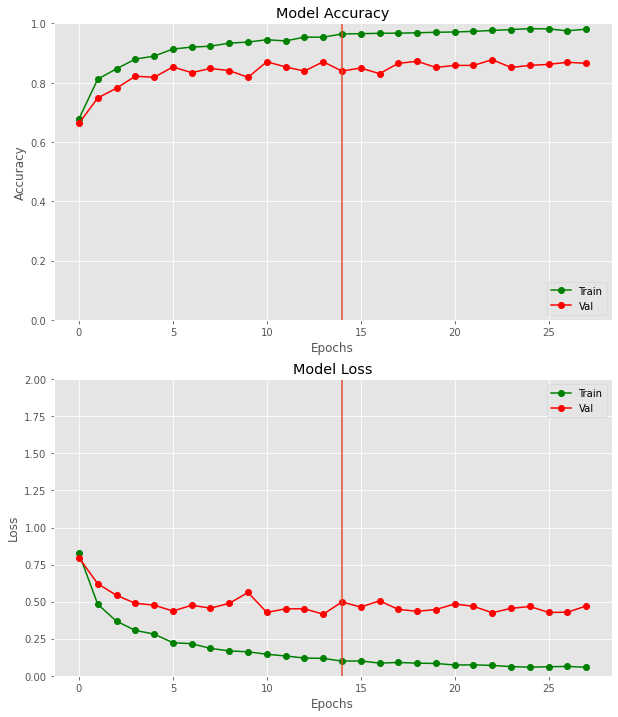

In [30]:
# Plot the training curves
train_acc += tuned_history.history['accuracy']
val_acc += tuned_history.history['val_accuracy']

train_loss += tuned_history.history['loss']
val_loss += tuned_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### **5.2 Confusion matrix and classification report**

In [31]:
# Get the labels
predictions = np.array([])
true_labels = np.array([])

for batch in range(len(test_data)):
    x, y = test_data[batch]
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])

# Look at the first 10 predictions and labels
print('predictions = ', predictions[:10])
print('True labels = ', true_labels[:10])

predictions =  [2. 1. 3. 1. 1. 1. 3. 1. 2. 1.]
True labels =  [2. 0. 3. 1. 0. 1. 3. 0. 2. 1.]


In [32]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 18  51  22   9]
 [  0 113   1   1]
 [  1   1 103   0]
 [  0   5   3  66]], shape=(4, 4), dtype=int32)


In [33]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.18      0.30       100
meningioma_tumor       0.66      0.98      0.79       115
        no_tumor       0.80      0.98      0.88       105
 pituitary_tumor       0.87      0.89      0.88        74

        accuracy                           0.76       394
       macro avg       0.82      0.76      0.71       394
    weighted avg       0.81      0.76      0.71       394



### **5.3 Save model performance**

In [34]:
report = classification_report(true_labels, predictions, target_names=test_data.class_indices.keys(), output_dict=True)
performance = {'Model': [],
               'Train accuracy': [],
               'Train loss': [],
               'Test accuracy': [],
               'Test loss': [],
               'Glioma Precision': [],
               'Glioma Recall': [],
               'Meningioma Precision': [],
               'Meningioma Recall': [],
               'No Tumor Precision': [],
               'No Tumor Recall': [],
               'Pituitary Precision': [],
               'Pituitary Recall': []
               }

performance['Model'].append('EfficientNetB1 model')
performance['Train accuracy'].append(train_acc[-1])
performance['Train loss'].append(train_loss[-1])
performance['Test accuracy'].append(test_accuracy)
performance['Test loss'].append(test_loss)
performance['Glioma Precision'].append(report['glioma_tumor']['precision'])
performance['Glioma Recall'].append(report['glioma_tumor']['recall'])
performance['Meningioma Precision'].append(report['meningioma_tumor']['precision'])
performance['Meningioma Recall'].append(report['meningioma_tumor']['recall'])
performance['No Tumor Precision'].append(report['no_tumor']['precision'])
performance['No Tumor Recall'].append(report['no_tumor']['recall'])
performance['Pituitary Precision'].append(report['pituitary_tumor']['precision'])
performance['Pituitary Recall'].append(report['pituitary_tumor']['recall'])

df_performance = pd.DataFrame(performance)
df_performance.to_csv('EfficientNetB1_performance.csv', index=False)